# Reconhecimento de Entidades usando a arquitetura BERT

In [2]:
import json, pickle

import pandas as pd
import numpy as np

from functools import reduce

import spacy
from spacy.gold import biluo_tags_from_offsets 

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.7.0'

In [192]:
harem = json.load(open("../data/external/MiniHAREM-selective.json", encoding="utf-8"))

In [193]:
tceset = pickle.load(open(r'../data/raw/v2/annotated.pkl','rb'))

In [194]:
TRAIN_DATA = []

for h in harem:
    TRAIN_DATA.append((h['doc_text'], 
     {'entities': [(e['start_offset'], e['end_offset'], e['label'])for e in h['entities']]}))

In [195]:
new_tce = []
for t in tceset:
    new_tce.append((t['content'], {'entities':[(e[0],e[1],e[2]) for e in t['entities']]}))

In [196]:
new_tce

[('de: "ddp" <ddp@tce.rn.gov.br>  para: "infocex" <infocex@tce.rn.gov.br>  enviadas: quarta-feira, 5 de fevereiro de 2020 16:23:24  assunto: solicitação de dados - caop mprn   com os cumprimentos de estilo, solicito extração de dados referente a informações em anexo pleiteadas pelo caop acerca de pagamentos e empenhos endereçados a determinados servidores públicos.  .  grato desde já.   victor rafael  auditor de controle externo  diretoria de despesa com pessoal \r',
  {'entities': [(11, 28, 'EMAIL'),
    (48, 69, 'EMAIL'),
    (82, 118, 'TEMPO'),
    (295, 305, 'CONTROLEEXTERNO'),
    (308, 316, 'CONTROLEEXTERNO')]}),
 (' com os cumprimentos de estilo, para atendimento ao pleito em anexo (processo 14312020) solicito extração de informações atinentes a existência de guarda municipal (com os respectivo quantitativo de agentes) nos municípios potiguares.   grato desde já.   victor rafael  diretoria de despesa com pessoal \r',
  {'entities': [(69, 86, 'CONTROLEEXTERNO'),
    (147, 163, 'C

In [197]:
TRAIN_DATA.extend(new_tce)

In [198]:
synth_train_data = pickle.load(open(r'../data/interim/synth_train_data.pkl','rb'))

In [199]:
TRAIN_DATA.extend(synth_train_data)

In [200]:
nlp = spacy.load('pt_core_news_lg')
docs = []
n_frase = 0
for text, annot in TRAIN_DATA:
    doc = nlp(text)
    n_frases = reduce(lambda x,y: x+y, [[n_frase + i] * len(s) for i,s in enumerate(nlp(text).sents)])
    last_n_frases = n_frases[-1]
    docs.extend(list(zip(n_frases, [d for d in doc], biluo_tags_from_offsets(doc, annot['entities']))))
    n_frase = last_n_frases + 1
    
    # then convert L->I and U->B to have IOB tags for the tokens in the doc

<ipython-input-200-a8720e31ec0a>:11: UserWarning: [W030] Some entities could not be aligned in the text "
  Um pouco de HISTÓRIA

No passado dia 7 de Dezem..." with entities "[(40, 53, 'TEMPO'), (68, 115, 'PESSOA'), (186, 220...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  docs.extend(list(zip(n_frases, [d for d in doc], biluo_tags_from_offsets(doc, annot['entities']))))
<ipython-input-200-a8720e31ec0a>:11: UserWarning: [W030] Some entities could not be aligned in the text "
A Assembleia aprovou ainda moções que reclamavam ..." with entities "[(3, 13, 'ORGANIZACAO'), (355, 364, 'PESSOA'), (36...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  docs.extend(list(zip(n_frases, [d for d in doc], biluo_tags_from_offsets(doc, annot['entities']))))
<ipython-input-200-a8720e3

In [206]:
df_bilou = pd.DataFrame(columns=['sentence','token','tag'])

In [207]:
for sentence, token, tag in docs:
    df_bilou = df_bilou.append({'sentence':sentence,'token':token.text, 'tag':tag}, ignore_index=True)

In [208]:
len(df_bilou)

79960

In [215]:
df_bilou.to_pickle('../data/interim/servus_bilou.pkl')

## BERT NN

In [12]:
df_bilou = pd.read_pickle('../data/interim/servus_bilou.pkl')

In [13]:
def biluo2bio(t):
    return t.replace("U-","B-").replace("L-","I-")

In [14]:
df_bilou['tag'] = df_bilou.tag.apply(biluo2bio)

In [15]:
df_bilou.loc[df_bilou.tag == '-', "tag"] = 'O'
df_bilou.loc[df_bilou.tag.str.contains('CARGO'), "tag"] = 'O'
df_bilou.loc[df_bilou.tag.str.contains('TELEFONE'), "tag"] = 'O'

In [16]:
df_bilou.tag.unique()

array(['O', 'B-PESSOA', 'I-PESSOA', 'B-LOCAL', 'I-LOCAL', 'B-TEMPO',
       'I-TEMPO', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-VALOR', 'I-VALOR',
       'B-EMAIL', 'B-CONTROLEEXTERNO', 'I-CONTROLEEXTERNO', 'B-DOCUMENTO',
       'I-DOCUMENTO'], dtype=object)

In [17]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p) for w, p in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [18]:
getter = SentenceGetter(df_bilou)

In [19]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
#sentences[0]

In [20]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
#print(labels[0])

In [21]:
tag_values = list(set(df_bilou["tag"].values))
tag_values.sort()
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [22]:
tag_values

['B-CONTROLEEXTERNO',
 'B-DOCUMENTO',
 'B-EMAIL',
 'B-LOCAL',
 'B-ORGANIZACAO',
 'B-PESSOA',
 'B-TEMPO',
 'B-VALOR',
 'I-CONTROLEEXTERNO',
 'I-DOCUMENTO',
 'I-LOCAL',
 'I-ORGANIZACAO',
 'I-PESSOA',
 'I-TEMPO',
 'I-VALOR',
 'O',
 'PAD']

In [228]:
MAX_LEN = 50
bs = 8

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [230]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
#model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [231]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [232]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [233]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [234]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [235]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [236]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [237]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [238]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [239]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [240]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.3.1'

In [241]:
model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
);

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [242]:
torch.cuda.empty_cache()

import gc
#del model
gc.collect()

456

In [243]:
model.cuda();

In [244]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [269]:
from transformers import get_linear_schedule_with_warmup

epochs = 100
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [270]:
from seqeval.metrics import f1_score, accuracy_score

In [271]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

#for _ in trange(epochs, desc="Epoch"):
for e in range(epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    print("Epoch {}".format(e))
    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch 0
Average train loss: 0.027869748571976917
Validation loss: 0.2060982685923451
Validation Accuracy: 0.9638858065166952
Validation F1-Score: 0.7917205692108668

Epoch 1
Average train loss: 0.03209898583258084
Validation loss: 0.21331601576642312
Validation Accuracy: 0.9640875617875517
Validation F1-Score: 0.7926023778071334

Epoch 2
Average train loss: 0.02526698584786149
Validation loss: 0.23146621217993715
Validation Accuracy: 0.9617673761727025
Validation F1-Score: 0.7828418230563002

Epoch 3
Average train loss: 0.01740508746415923
Validation loss: 0.22384681555234306
Validation Accuracy: 0.9648945828709775
Validation F1-Score: 0.8092643051771118

Epoch 4
Average train loss: 0.01727180549090145
Validation loss: 0.2142590940271755
Validation Accuracy: 0.9677191566629678
Validation F1-Score: 0.8282416836388322

Epoch 5
Average train loss: 0.01711770737456889
Validation loss: 0.20979479151736505
Validation Accuracy: 0.966004236860688
Validation F1-Score: 0.8178694158075601

Epoch 

Average train loss: 0.005367689549950527
Validation loss: 0.3006082640864966
Validation Accuracy: 0.9692323211943912
Validation F1-Score: 0.8337988826815642

Epoch 50
Average train loss: 0.0070136351628300635
Validation loss: 0.35169370978090647
Validation Accuracy: 0.9644910723292646
Validation F1-Score: 0.7997265892002734

Epoch 51
Average train loss: 0.006576486744737326
Validation loss: 0.319404546514796
Validation Accuracy: 0.9666095026732573
Validation F1-Score: 0.8211551844119694

Epoch 52
Average train loss: 0.005379479662638441
Validation loss: 0.32173785431469487
Validation Accuracy: 0.9646928276001211
Validation F1-Score: 0.8080110497237569

Epoch 53
Average train loss: 0.0045344457304048
Validation loss: 0.3420607953935989
Validation Accuracy: 0.9641884394229799
Validation F1-Score: 0.7994616419919246

Epoch 54
Average train loss: 0.005149097821773366
Validation loss: 0.3294535570721844
Validation Accuracy: 0.966912135579542
Validation F1-Score: 0.8112449799196788

Epoch 55

Average train loss: 0.003159178460124815
Validation loss: 0.356527361064134
Validation Accuracy: 0.9667103803086856
Validation F1-Score: 0.8221614227086183

Epoch 99
Average train loss: 0.0033277414715737357
Validation loss: 0.3564316012414985
Validation Accuracy: 0.9668112579441138
Validation F1-Score: 0.8215994531784004



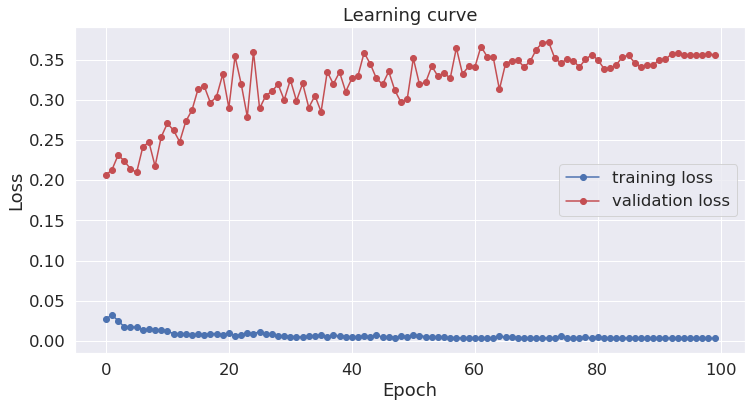

In [272]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [281]:
torch.save(model, '../models/ner_servus_0.0.1.pt')
torch.save(model.state_dict(), '../models/ner_servus_sd_0.0.1.pt')

## Aplicação do modelo

In [125]:
def get_entities_from_message(msg, model, tokenizer):
    tokenized_sentence = tokenizer.encode(msg)
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            
    zip_result = list(zip(new_labels, new_tokens))
    
    for label, token in zip_result:
        print("{}\t{}".format(label, token))
    
    words = []
    ents = []
    for e in [r for r in zip_result if r[0] != 'O']:
        symb, t_ent = e[0].split('-')
        word = e[1]
        if symb == 'B':
            words.append(word)
            ents.append(t_ent)
        else:
            words[-1] += ' ' + word
            
    return list(zip(words, ents))
    

In [126]:
model = torch.load('../models/ner_servus_0.0.1.pt')

In [127]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

In [128]:
msg_despesa_publica = """
Gostaria de solicitar empenhos, licitações e contratos dos meses de janeiro a março de 2018 da Prefeitura 
do Natal pagos a João da Silva (CPF 059.112.043-12) e para a empresa XXX (CNPJ 00.000.000/0001-91 )
no valor de R$ 10.000,00.
"""
msg_despesa_pessoal = """
Quero saber a folha de pagaemto e os acúmulos de cargos na prefeitura de Mossoró também. Mande o resultado para fulano@tce.rn.gov.br. Folha de papel
"""
msg_errada = """
empenhs e pagumentos da prefeitura de caico
"""

In [129]:
res = get_entities_from_message(msg_errada, model, tokenizer)

O	[CLS]
B-CONTROLEEXTERNO	empenhs
O	e
B-CONTROLEEXTERNO	pagumentos
O	da
B-ORGANIZACAO	prefeitura
I-ORGANIZACAO	de
I-ORGANIZACAO	caico
O	[SEP]


In [131]:
res = get_entities_from_message(msg_despesa_publica, model, tokenizer)

O	[CLS]
O	Gostaria
O	de
O	solicitar
B-CONTROLEEXTERNO	empenhos
O	,
B-CONTROLEEXTERNO	licitações
O	e
B-CONTROLEEXTERNO	contratos
O	dos
O	meses
O	de
B-TEMPO	janeiro
I-TEMPO	a
B-TEMPO	março
I-TEMPO	de
I-TEMPO	2018
O	da
B-ORGANIZACAO	Prefeitura
I-ORGANIZACAO	do
I-ORGANIZACAO	Natal
O	pagos
O	a
B-ORGANIZACAO	João
I-ORGANIZACAO	da
I-ORGANIZACAO	Silva
O	(
O	CPF
B-DOCUMENTO	059
B-DOCUMENTO	.
B-DOCUMENTO	112
B-DOCUMENTO	.
I-DOCUMENTO	043
I-DOCUMENTO	-
I-DOCUMENTO	12
O	)
O	e
O	para
O	a
O	empresa
B-ORGANIZACAO	XXX
O	(
O	CNPJ
B-DOCUMENTO	00
B-DOCUMENTO	.
B-DOCUMENTO	000
B-DOCUMENTO	.
B-DOCUMENTO	000
B-DOCUMENTO	/
I-DOCUMENTO	0001
I-DOCUMENTO	-
I-DOCUMENTO	91
O	)
O	no
O	valor
O	de
B-VALOR	R
B-VALOR	$
I-VALOR	10
I-VALOR	.
I-VALOR	000
I-VALOR	,
I-VALOR	00
O	.
O	[SEP]


In [132]:
res

[('empenhos', 'CONTROLEEXTERNO'),
 ('licitações', 'CONTROLEEXTERNO'),
 ('contratos', 'CONTROLEEXTERNO'),
 ('janeiro a', 'TEMPO'),
 ('março de 2018', 'TEMPO'),
 ('Prefeitura do Natal', 'ORGANIZACAO'),
 ('João da Silva', 'ORGANIZACAO'),
 ('059', 'DOCUMENTO'),
 ('.', 'DOCUMENTO'),
 ('112', 'DOCUMENTO'),
 ('. 043 - 12', 'DOCUMENTO'),
 ('XXX', 'ORGANIZACAO'),
 ('00', 'DOCUMENTO'),
 ('.', 'DOCUMENTO'),
 ('000', 'DOCUMENTO'),
 ('.', 'DOCUMENTO'),
 ('000', 'DOCUMENTO'),
 ('/ 0001 - 91', 'DOCUMENTO'),
 ('R', 'VALOR'),
 ('$ 10 . 000 , 00', 'VALOR')]

In [133]:
res = get_entities_from_message(msg_despesa_pessoal, model, tokenizer)

O	[CLS]
O	Quero
O	saber
O	a
B-CONTROLEEXTERNO	folha
I-CONTROLEEXTERNO	de
I-CONTROLEEXTERNO	pagaemto
O	e
O	os
B-CONTROLEEXTERNO	acúmulos
I-CONTROLEEXTERNO	de
I-CONTROLEEXTERNO	cargos
O	na
B-ORGANIZACAO	prefeitura
I-ORGANIZACAO	de
I-ORGANIZACAO	Mossoró
O	também
O	.
O	Mande
O	o
O	resultado
O	para
B-EMAIL	fulano
B-EMAIL	@
B-EMAIL	tce
B-EMAIL	.
B-EMAIL	rn
B-EMAIL	.
B-EMAIL	gov
B-EMAIL	.
B-EMAIL	br
O	.
O	Folha
O	de
O	papel
O	[SEP]


In [134]:
res

[('folha de pagaemto', 'CONTROLEEXTERNO'),
 ('acúmulos de cargos', 'CONTROLEEXTERNO'),
 ('prefeitura de Mossoró', 'ORGANIZACAO'),
 ('fulano', 'EMAIL'),
 ('@', 'EMAIL'),
 ('tce', 'EMAIL'),
 ('.', 'EMAIL'),
 ('rn', 'EMAIL'),
 ('.', 'EMAIL'),
 ('gov', 'EMAIL'),
 ('.', 'EMAIL'),
 ('br', 'EMAIL')]